In [28]:
import os
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import nilearn.plotting as niplot
from nilearn.masking import apply_mask
from scipy.ndimage import center_of_mass
from nilearn.image import mean_img
from scipy.ndimage import label


In [33]:
os.chdir("/Users/jan/Documents/example data/")

In [47]:
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
# mask_img = nib.load("graymattermask_resampled.nii.gz")
mask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")


# Extract data from one time point (e.g., the first volume)
fmri_data_4d = fmri_img.get_fdata()
fmri_volume = fmri_data_4d[..., 0]  # Choose volume 0 (can be any time index)

# Load and binarize the brain mask
mask_data = mask_img.get_fdata().astype(bool)

# Apply mask to fMRI
brain_only = fmri_volume * mask_data

# Compute center of mass from the mask
com = center_of_mass(mask_data)
x_c, y_c, z_c = map(int, com)
print(f"Brain Center of Mass: x={x_c}, y={y_c}, z={z_c}")

# Distinguishing the eyes
# eyes = fmri_volume - brain_only
eyes = brain_only

Brain Center of Mass: x=23, y=47, z=9


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



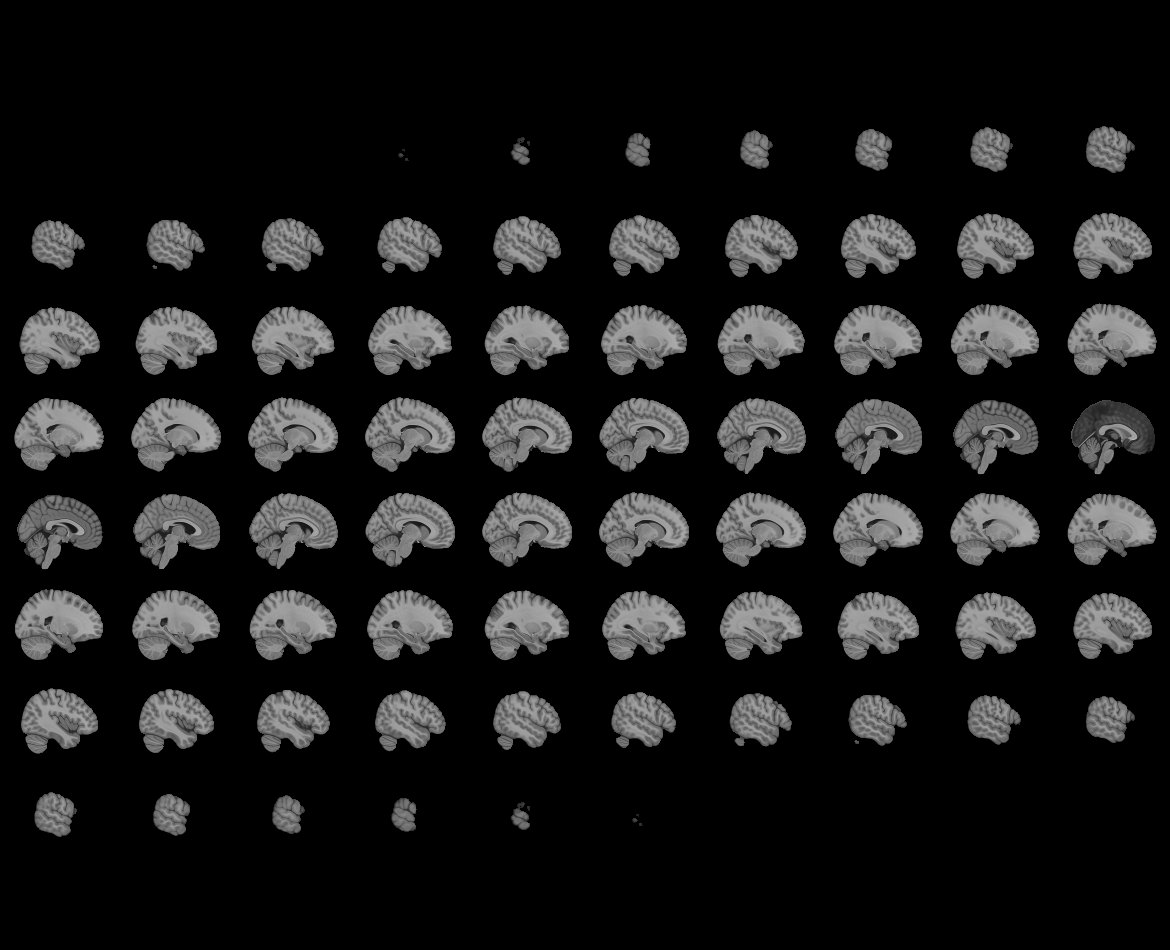
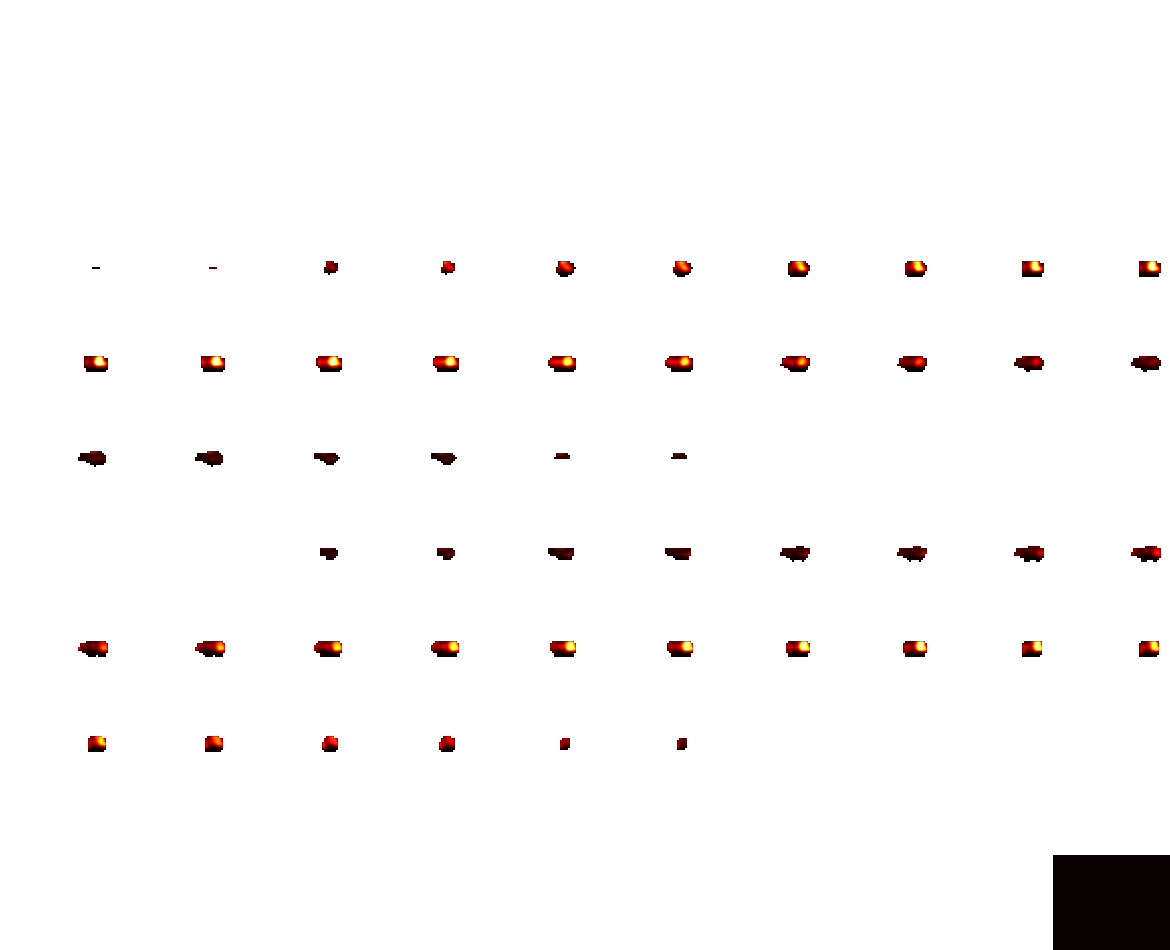

In [48]:
# brain without eyes

brain_only_img = nib.Nifti1Image(brain_only, affine=fmri_img.affine)
plotting.view_img(brain_only_img)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



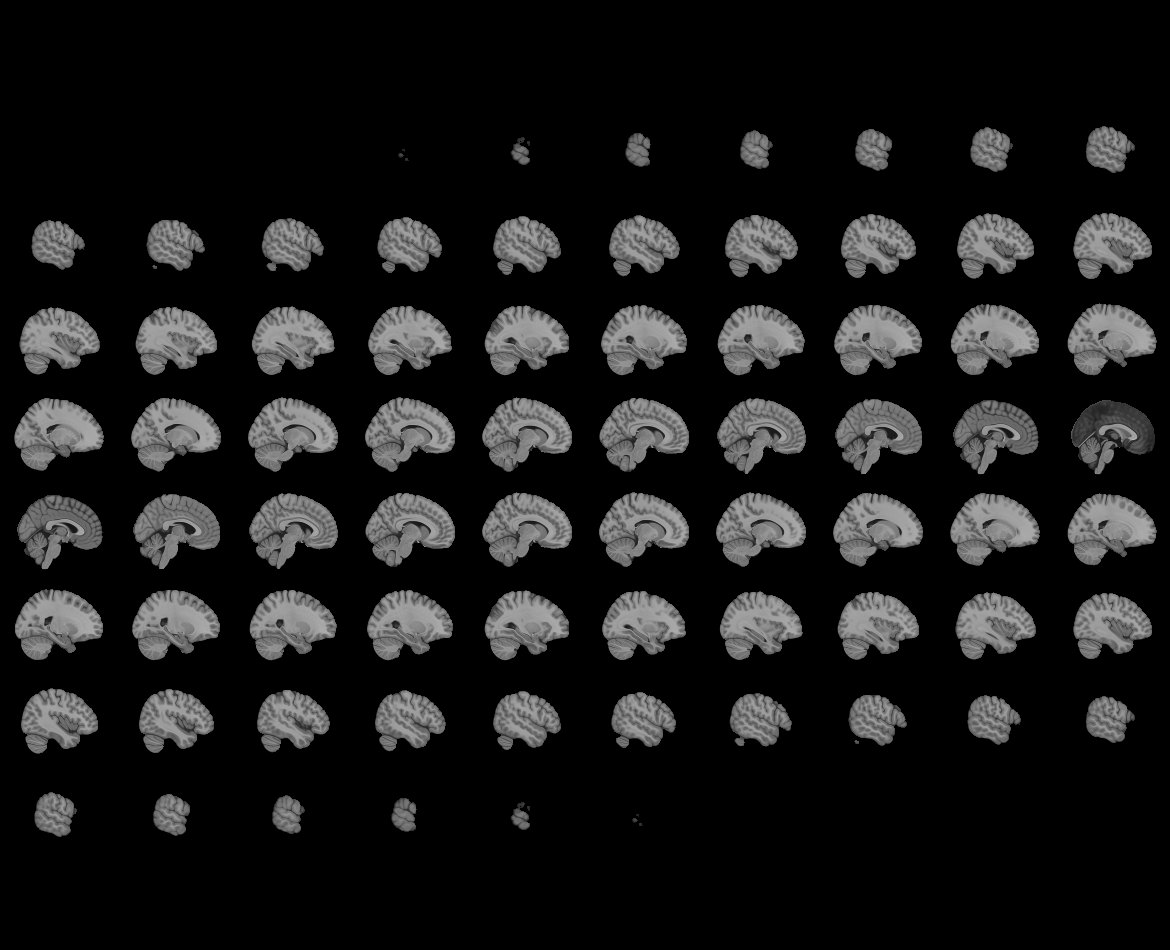
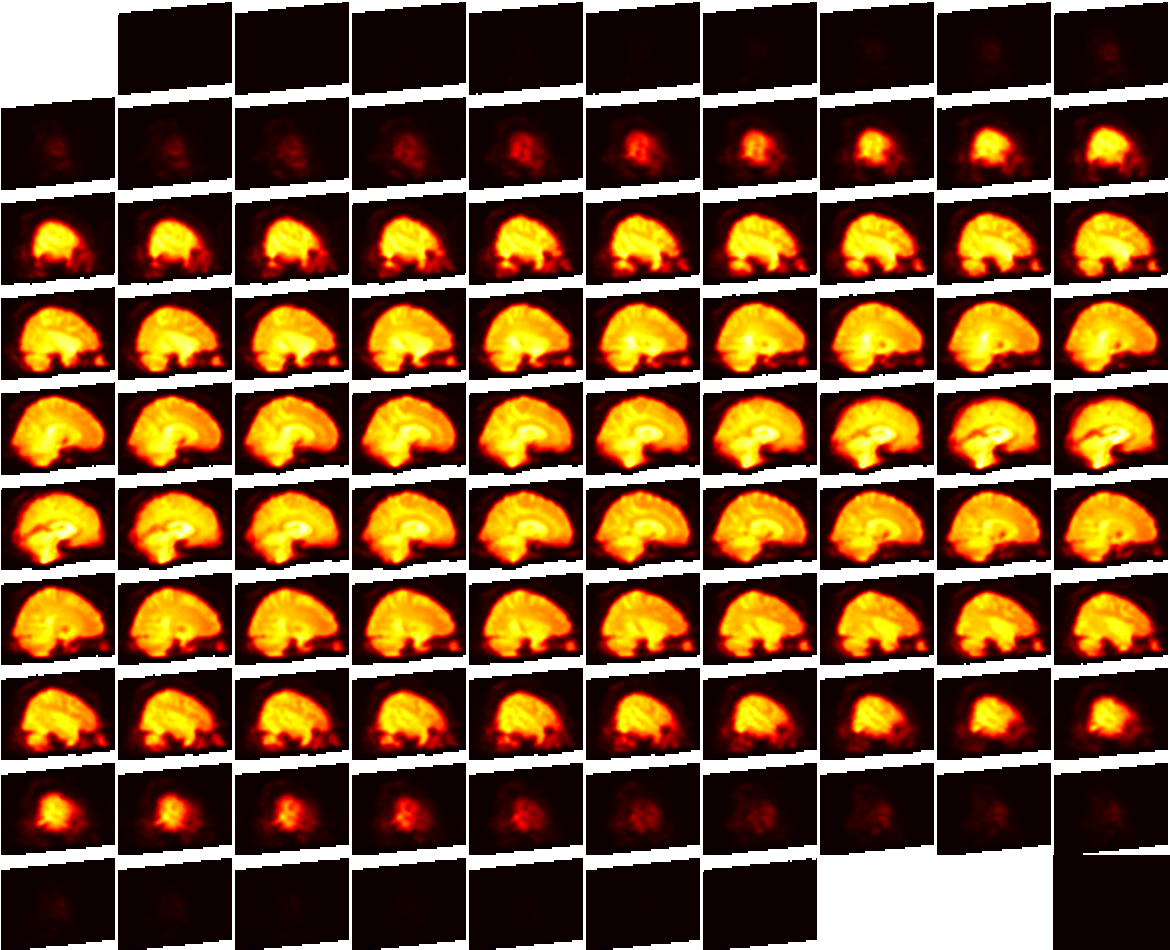

In [49]:
# brain with eyes

fmri_volume_img = nib.Nifti1Image(fmri_volume, affine=fmri_img.affine)
plotting.view_img(fmri_volume_img)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



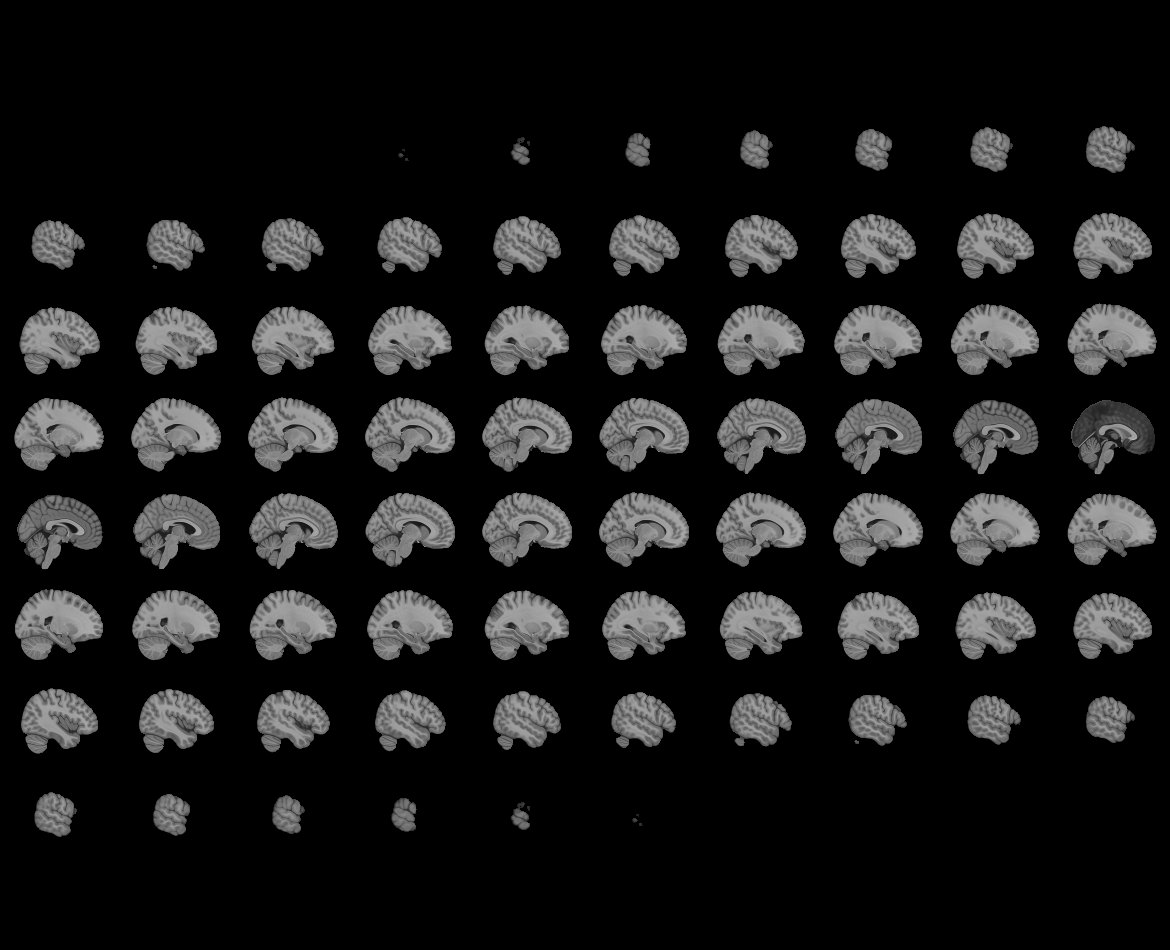
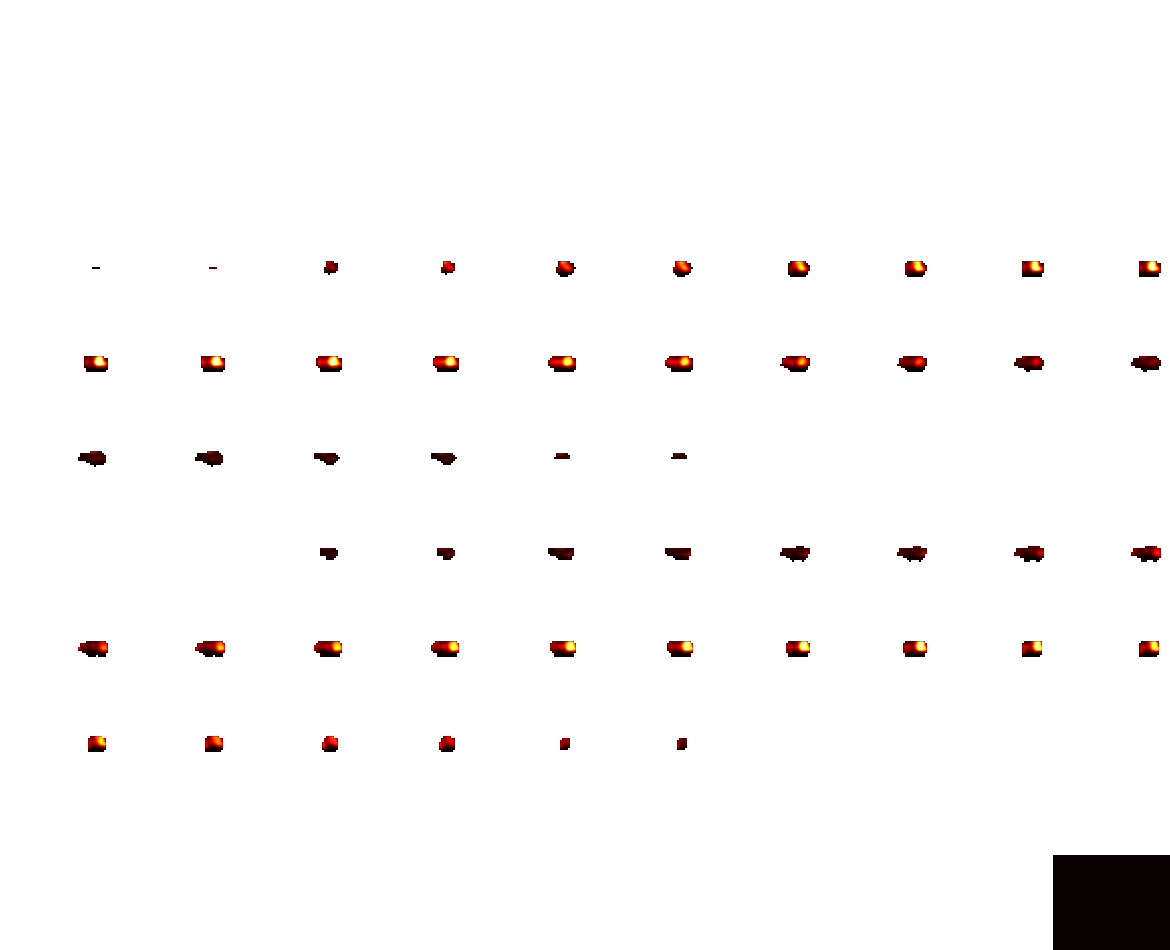

In [50]:
eyes_img = nib.Nifti1Image(eyes, affine=fmri_img.affine)
plotting.view_img(eyes_img)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



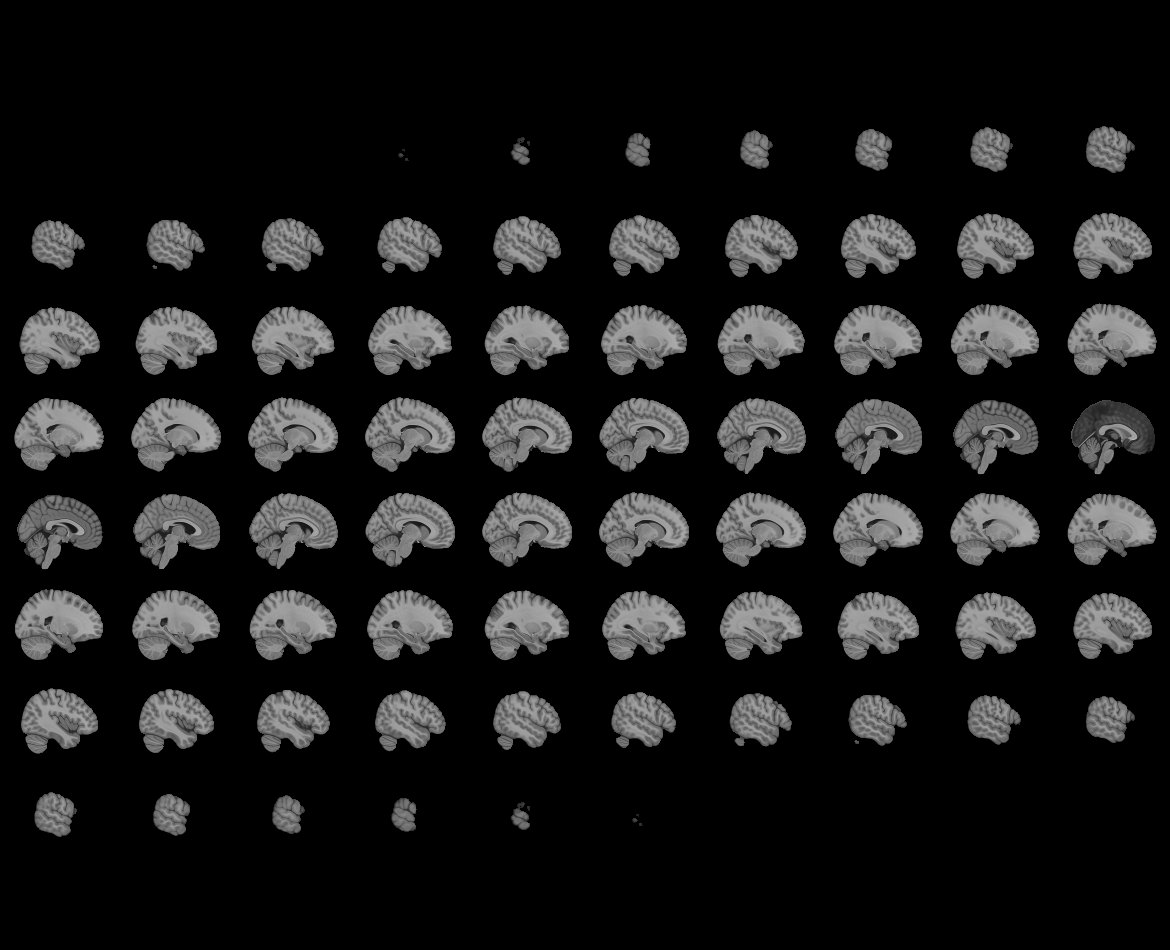
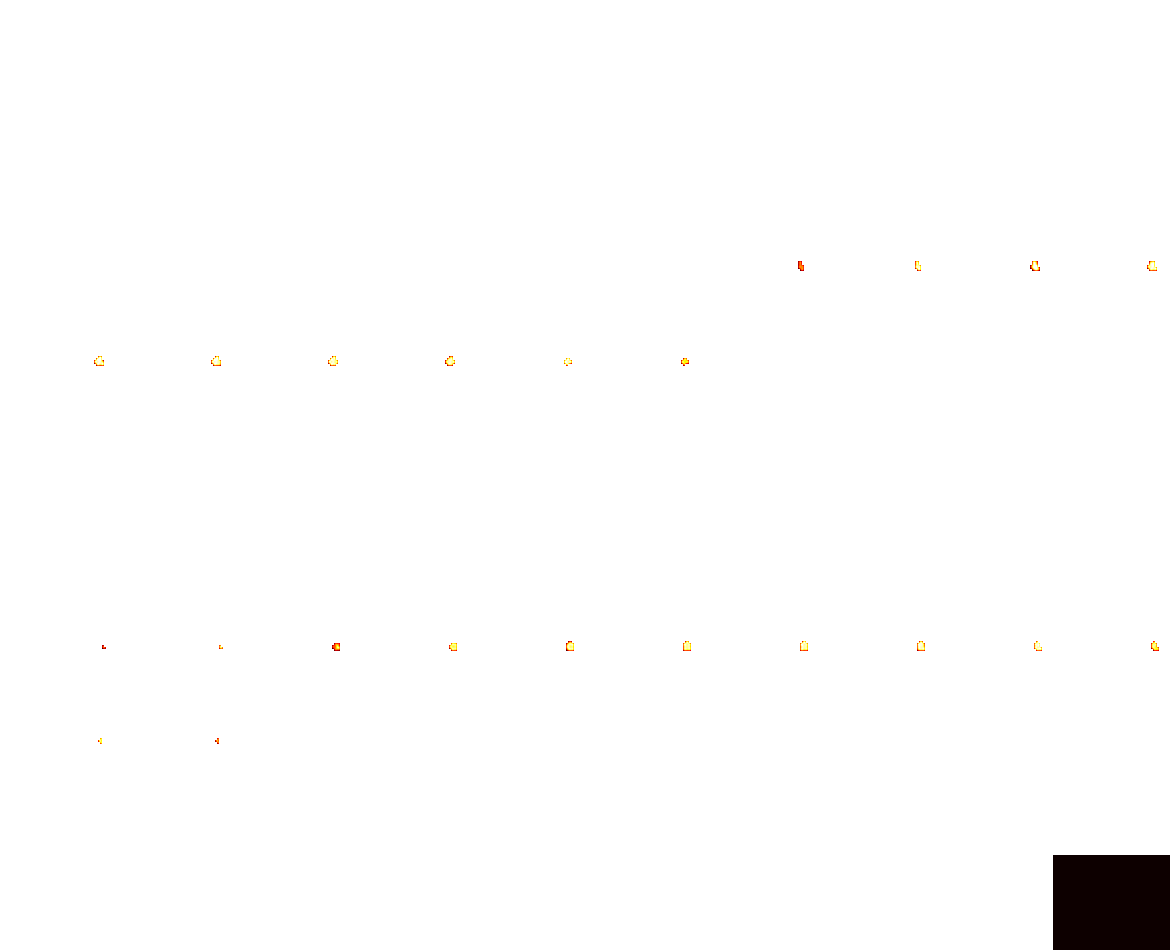

In [45]:
# # Define Y-axis bounds
# y_start = 100
# z_start = -70
# y_end = y_start - 59  # So y = 100 down to y = 40 (smaller values)
# z_end = z_start + 37

# # Mask the region of interest
# eyes_roi = np.zeros_like(eyes)
eyes_roi = eyes
# #eyes_roi[:, y_end:y_start, :] = eyes[:, y_end:y_start, :]
# eyes_roi[:, y_end:y_start, z_start:z_end] = eyes[:, y_end:y_start, z_start:z_end]

# Get top 100 brightest voxel indices within the ROI
flat_indices = np.argpartition(eyes_roi.ravel(), -150)[-150:]
sorted_flat_indices = flat_indices[np.argsort(eyes_roi.ravel()[flat_indices])[::-1]]
brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T

# Create empty image to store the brightest voxels
brightest_voxels_img = np.zeros_like(eyes)

# Set the intensity values at those coordinates
for x, y, z in brightest_coords:
    brightest_voxels_img[x, y, z] = eyes[x, y, z]  # You can also use eyes_roi here; same in that range

# Wrap into Nifti1Image using original affine
brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")

# Plot interactively
plotting.view_img(brightest_voxels_nii, threshold=0) # opacity=0.5

# largest and the second largest components

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



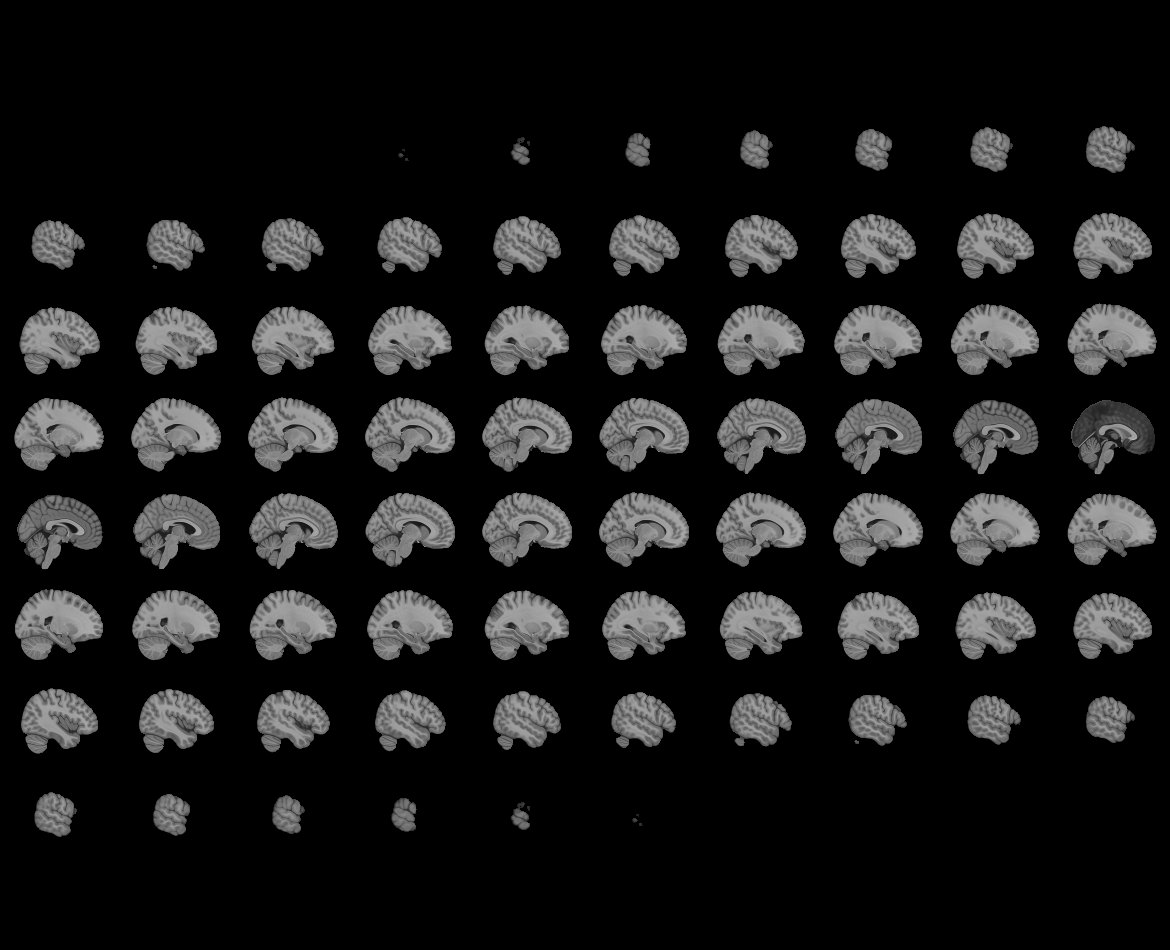
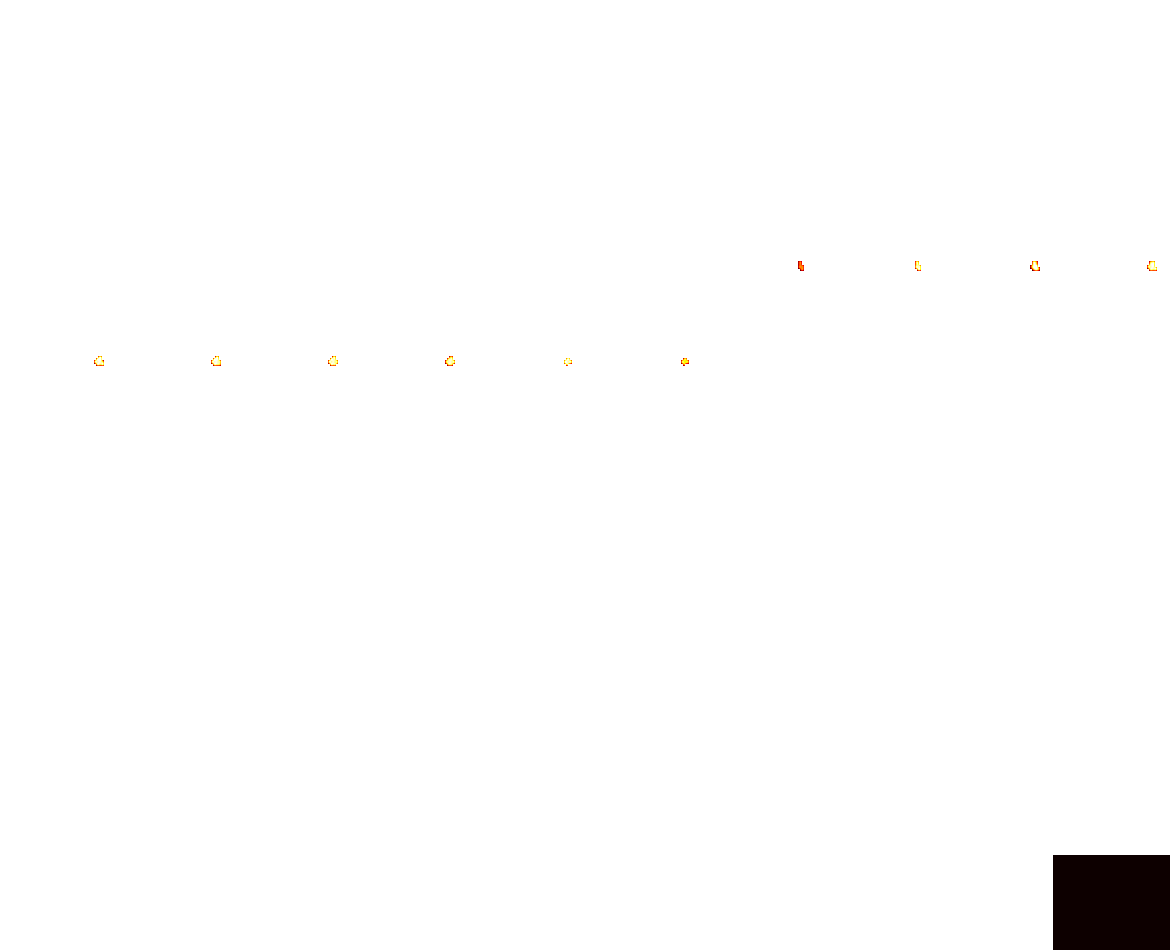

In [51]:
# Label connected components (regions of adjacent bright voxels)
labeled, num_labels = label(brightest_voxels_img)

# Find the size of each connected component (cluster)
component_sizes = np.bincount(labeled.ravel())

# Ignore background (label 0), sort the components by size and find the largest and second largest components
sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)

# Ignore background (label 0) and find the largest component
largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
largest_component = labeled == largest_component_label

second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
# Create an image of the largest component
largest_component_img = np.zeros_like(fmri_volume)
largest_component_img[largest_component] = fmri_volume[largest_component]

# Create the second largest component (second biggest cluster)
second_largest_component = labeled == second_largest_label

# Create an image of the second largest component
second_largest_img = np.zeros_like(fmri_volume)
second_largest_img[second_largest_component] = fmri_volume[second_largest_component]

# Wrap into a NIfTI image
second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)

# Wrap into a NIfTI image
largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)

# Create an image for both clusters combined (sum of both masks)
combined_clusters_img = np.zeros_like(fmri_volume)
combined_clusters_img[largest_component] = fmri_volume[largest_component]
combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]

# Wrap into a NIfTI image
combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)

# Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
largest_coords = np.column_stack(np.where(largest_component))
second_largest_coords = np.column_stack(np.where(second_largest_component))

largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]

if largest_coords_world[0][0] < 0:
    left_eye_img = largest_component_nii
    right_eye_img = second_largest_nii
else:
    left_eye_img = second_largest_nii
    right_eye_img = largest_component_nii

# Save the combined clusters result
nib.save(combined_clusters_nii, "combined_clusters_brightest_voxels.nii.gz")

# Save the largest component
nib.save(left_eye_img, "left_eye.nii.gz")

# Save the second largest component
nib.save(right_eye_img, "right_eye.nii.gz")

# Plot interactively both clusters together (overlaying)
plotting.view_img(left_eye_img, threshold=0)

# Save the result


# Plot interactively
# plotting.view_img(second_largest_nii, threshold=0)

## Not used yet...

/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_stat_map.py:112: UserWarning: Threshold given was -1e-05, but the data has no values below 0.0. 
  warnings.warn(
/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



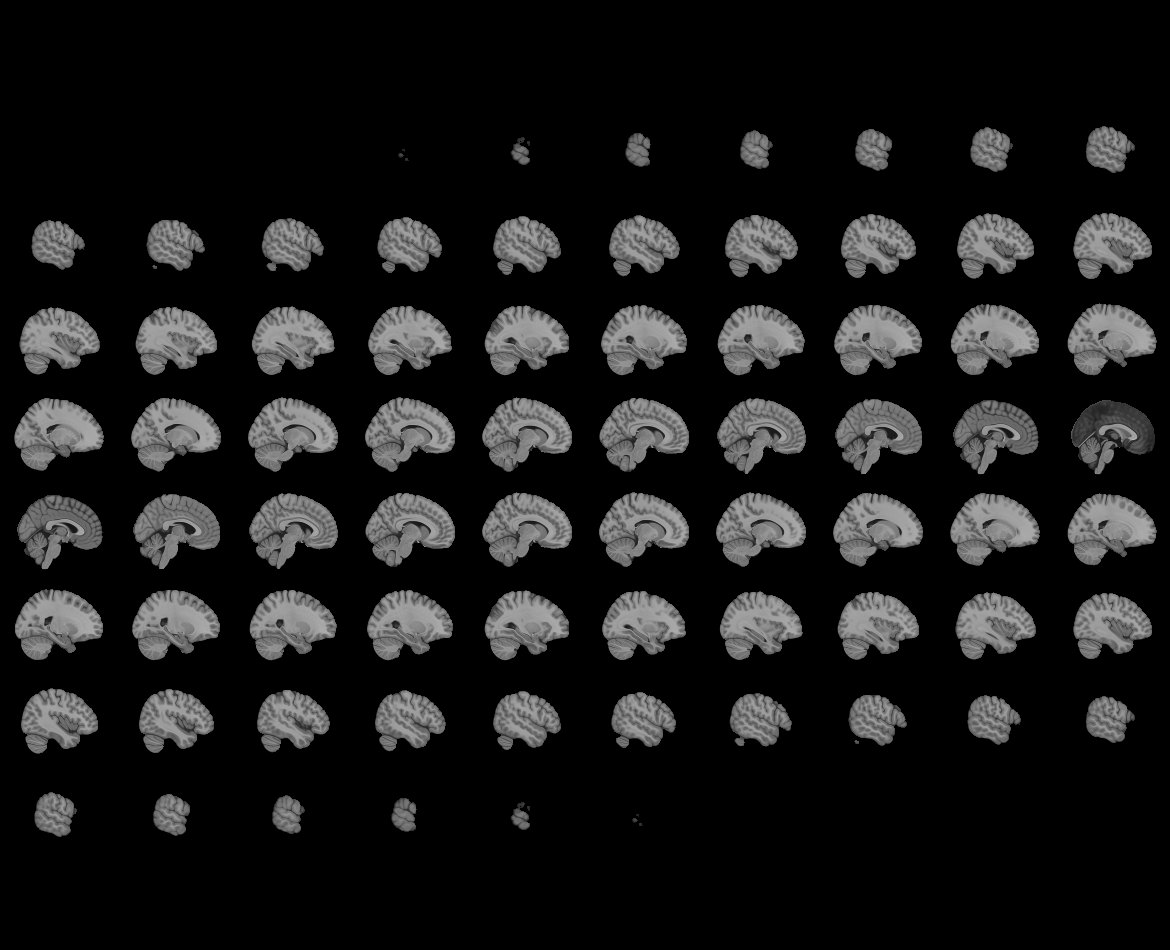
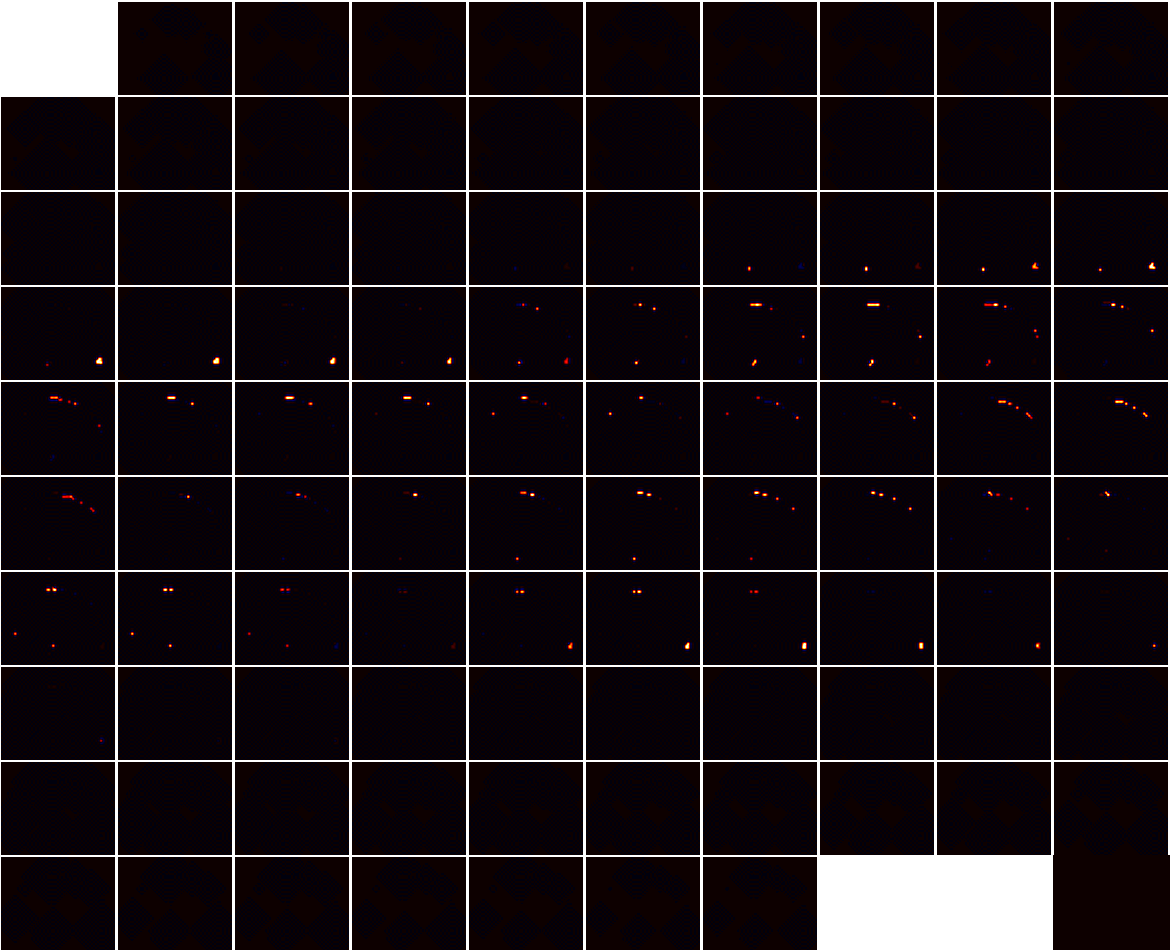

In [100]:
# Get top 100 brightest voxel indices
flat_indices = np.argpartition(eyes.ravel(), -100)[-100:]
sorted_flat_indices = flat_indices[np.argsort(eyes.ravel()[flat_indices])[::-1]]
brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes.shape)).T

# Create empty image to store the brightest voxels
brightest_voxels_img = np.zeros_like(eyes)

# Set the intensity values at those coordinates
for x, y, z in brightest_coords:
    brightest_voxels_img[x, y, z] = eyes[x, y, z]

# Wrap into Nifti1Image using original affine
brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)

# Plot using nilearn's interactive viewer
plotting.view_img(brightest_voxels_nii, threshold='auto')

In [80]:
# Remove negative values from subtraction (if any)
eyes = np.clip(eyes, a_min=0, a_max=None)

# Use intensity threshold to keep only bright blobs
threshold = np.percentile(eyes[eyes > 0], 90)  # Top 1% intensity
eyes_thresh = eyes > threshold

In [ ]:
# Extract 100 brightest voxels
# Ensure all values are non-negative
eyes = np.clip(eyes, a_min=0, a_max=None)

# Get the 100 brightest voxel indices (flattened)
flat_indices = np.argpartition(eyes.ravel(), -100)[-100:]
sorted_flat_indices = flat_indices[np.argsort(eyes.ravel()[flat_indices])[::-1]]

# Get 3D coordinates of those voxels
brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes.shape)).T  # shape: (100, 3)

In [ ]:
# Create a New Volume Showing Only the Brightest Voxels

# Create empty mask
brightest_voxels_mask = np.zeros_like(eyes, dtype=bool)

# Set the 100 brightest voxel positions to True
for x, y, z in brightest_coords:
    brightest_voxels_mask[x, y, z] = True

# Optionally, extract intensities at those voxels
brightest_values = eyes[brightest_voxels_mask]

In [84]:
# Make sure eyes has only non-negative values
eyes = np.clip(eyes, a_min=0, a_max=None)

# Flatten the 3D image and get indices of 100 brightest values
flat_indices = np.argpartition(eyes.ravel(), -100)[-100:]  # Get top 100 indices (unsorted)

# Sort them in descending order of intensity
sorted_flat_indices = flat_indices[np.argsort(eyes.ravel()[flat_indices])[::-1]]

# Convert flat indices back to 3D coordinates
brightest_voxel_coords = np.array(np.unravel_index(sorted_flat_indices, eyes.shape)).T  # Shape: (100, 3)

# Print them
for i, (x, y, z) in enumerate(brightest_voxel_coords):
    print(f"{i+1:3d}: Voxel at (x={x}, y={y}, z={z}) — Intensity: {eyes[x, y, z]:.2f}")

  1: Voxel at (x=19, y=29, z=39) — Intensity: 808.02
  2: Voxel at (x=21, y=27, z=40) — Intensity: 806.91
  3: Voxel at (x=29, y=27, z=39) — Intensity: 801.62
  4: Voxel at (x=18, y=27, z=39) — Intensity: 799.30
  5: Voxel at (x=30, y=24, z=39) — Intensity: 795.94
  6: Voxel at (x=18, y=26, z=11) — Intensity: 785.47
  7: Voxel at (x=18, y=28, z=39) — Intensity: 784.61
  8: Voxel at (x=18, y=26, z=39) — Intensity: 781.78
  9: Voxel at (x=20, y=27, z=40) — Intensity: 781.00
 10: Voxel at (x=17, y=25, z=10) — Intensity: 774.64
 11: Voxel at (x=21, y=28, z=40) — Intensity: 774.49
 12: Voxel at (x=18, y=25, z=39) — Intensity: 770.03
 13: Voxel at (x=21, y=26, z=40) — Intensity: 761.06
 14: Voxel at (x=20, y=26, z=40) — Intensity: 757.05
 15: Voxel at (x=30, y=26, z=39) — Intensity: 750.01
 16: Voxel at (x=19, y=30, z=39) — Intensity: 747.98
 17: Voxel at (x=32, y=26, z=38) — Intensity: 743.62
 18: Voxel at (x=27, y=31, z=39) — Intensity: 734.58
 19: Voxel at (x=20, y=28, z=40) — Intensity: 

In [81]:
from scipy.ndimage import label, center_of_mass

# Label connected components
labeled_eyes, num_features = label(eyes_thresh)

print(f"Found {num_features} bright regions outside the brain")

# Analyze each component
eye_candidates = []

for i in range(1, num_features + 1):
    component = (labeled_eyes == i)
    size = np.sum(component)
    com = center_of_mass(component)

    # Filter based on size and location
    if 100 < size < 2000:  # Tune these based on voxel size
        if com[1] > y_c:  # Must be anterior to brain
            eye_candidates.append((i, size, com))

Found 125 bright regions outside the brain


In [82]:
# Sort by size
eye_candidates = sorted(eye_candidates, key=lambda x: -x[1])

# Pick top 2 (assume they’re the eyes)
eye_labels = [c[0] for c in eye_candidates[:2]]

# Create binary mask of just the eyes
final_eye_mask = np.isin(labeled_eyes, eye_labels)

In [83]:
z_eye = int(np.mean([com[2] for _, _, com in eye_candidates[:2]]))  # Approx eye-level
plt.imshow(np.rot90(final_eye_mask[:, :, z_eye]), cmap='gray')
plt.title(f"Detected Eyes (axial slice z={z_eye})")
plt.axis("off")
plt.show()

ValueError: cannot convert float NaN to integer

In [66]:
# Set how many slices forward to scan from the brain
steps_forward = 30
eye_candidate_slices = []

for dy in range(1, steps_forward):
    y_pos = y_c + dy
    if y_pos >= fmri_volume.shape[1]:
        break
    anterior_slice = fmri_volume[:, y_pos, :]
    eye_candidate_slices.append((y_pos, anterior_slice))

In [10]:
smoothed_data=smooth.get_fdata()

In [11]:
smoothed_data.shape

(49, 58, 49, 128)

In [12]:
middle_slice=smoothed_data[:,:,:,64]

In [13]:
affine = smooth.affine

In [14]:
middle_slice_img=nib.Nifti1Image(middle_slice, affine)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



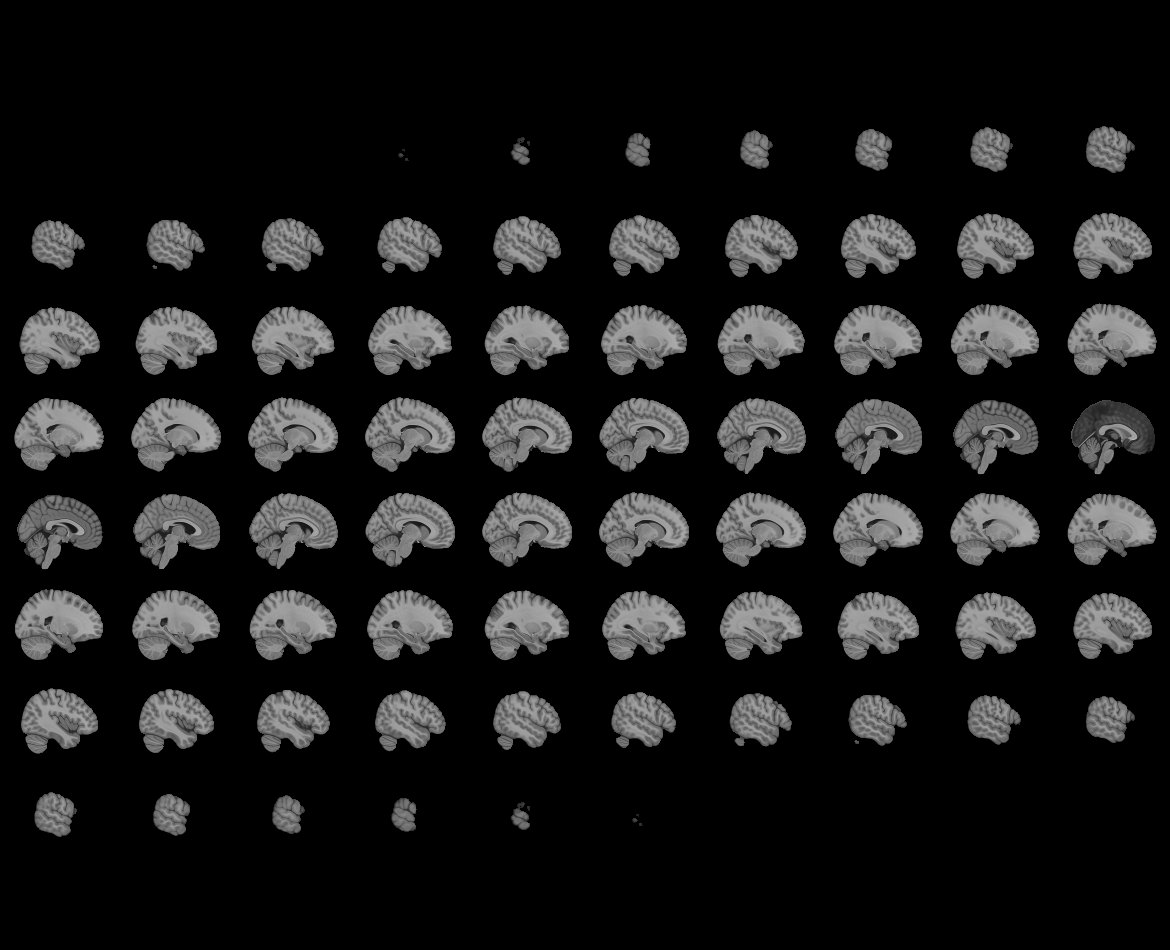
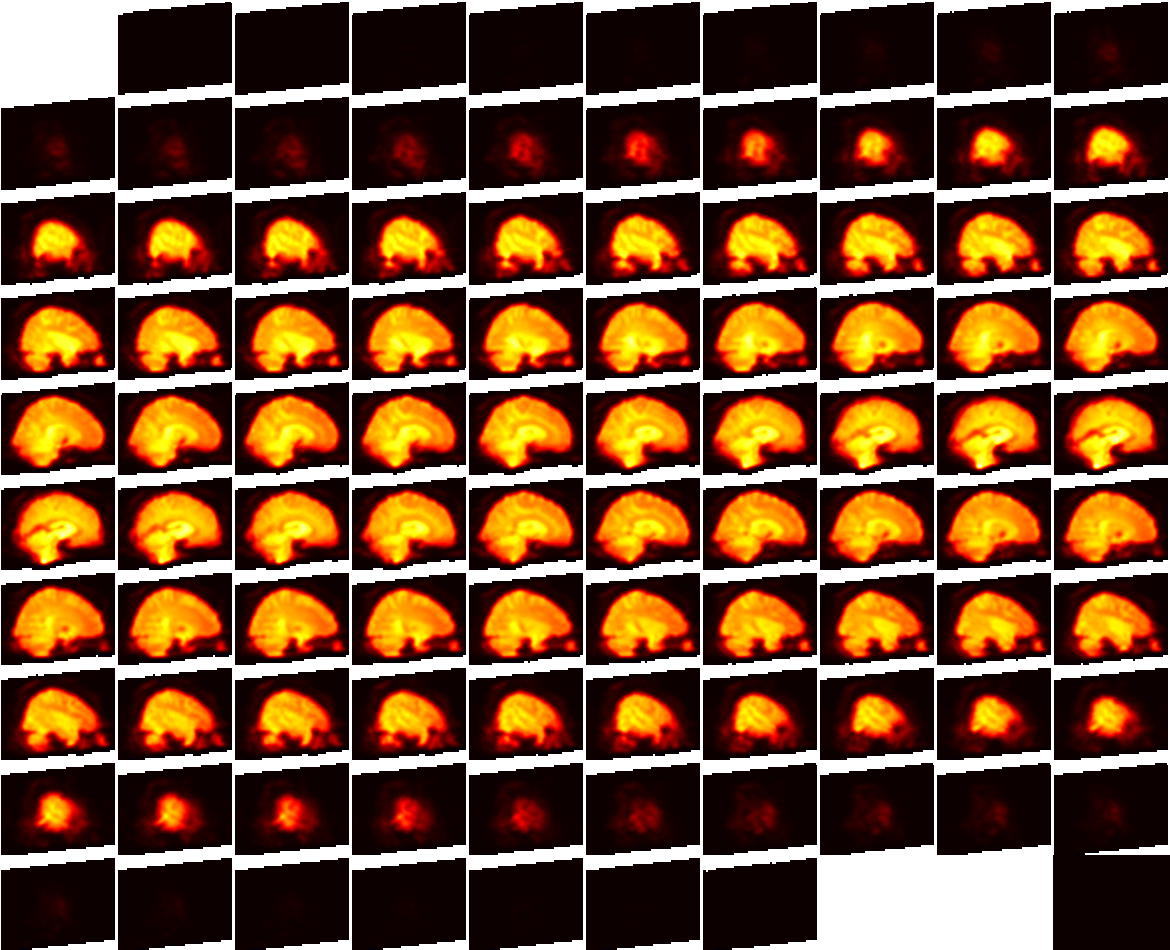

In [15]:
plotting.view_img(middle_slice_img)